In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

from src import *

In [10]:
n = 100
alpha = 1e-8

training_time = 600  # training time/
testing_time = 100
frac = 0.5
dt = 0.01

w_in_sigma = 0.004

gateR = 2.7e4
gateC = 8.98e-7
pinchoff = -0.6

parameters = dict()
parameters["transconductance"] = {"mean": 0.582e-3, "stddev": 0.0582e-3}
parameters["channel-width"] = {"mean": 200e-6, "stddev": 0}
parameters["channel-length"] = {"mean": 101e-6, "stddev": 0}
parameters["pinchoff-voltage"] = {"mean": pinchoff, "stddev": 0}  # pinch-off voltage
parameters["weighting-resistor"] = {"mean": 500, "stddev": 100}
parameters["gate-capacitance"] = {"mean": gateC, "stddev": 0.1 * gateC}
parameters["gate-resistance"] = {"mean": gateR, "stddev": 0.1 * gateR}
parameters["applied-drain-voltage"] = {"mean": -0.05, "stddev": 0}

# system
D = 3
r_dist = uniform(100, 500)
delta_dist = norm(scale=0.000000005)
p = 10 / n
sigma = 10
rho = 28
beta = 8 / 3

In [11]:
u0list = generate_initial_conditions(
    1,
    [-7.4, -11.1, 20],
    delta_dist,
    5000,
    0.001,
    lorenz,
    sigma=10,
    rho=28,
    beta=8 / 3,
)

u0 = u0list[0]

In [12]:
# OECT parameters
Vdinit, R, Rg, Cg, Vp, Kp, W, L = generate_OECT_parameters(n, parameters)

A = erdos_renyi_network(n, p, r_dist)

w_in = input_layer(D, n, w_in_sigma)

In [13]:
w_out, uf, r0, V1_0 = train_oect_reservoir(
    u0.copy(),
    training_time,
    dt,
    frac,
    w_in,
    A,
    alpha,
    Vdinit,
    R,
    Rg,
    Cg,
    Vp,
    Kp,
    W,
    L,
    lorenz,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

In [14]:
t, signal_oect, prediction_oect = run_oect_reservoir_autonomously(
    uf,
    r0,
    V1_0,
    testing_time,
    dt,
    w_in,
    w_out,
    A,
    Vdinit,
    R,
    Rg,
    Cg,
    Vp,
    Kp,
    W,
    L,
    lorenz,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

In [15]:
w_out, uf, r = train_reservoir(
    u0.copy(),
    A,
    training_time,
    dt,
    frac,
    w_in,
    alpha,
    lorenz,
    0,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

In [16]:
## Run reservoir autonomously.
t, signal_tanh, prediction_tanh = run_reservoir_autonomously(
    uf,
    r,
    A,
    testing_time,
    dt,
    w_in,
    w_out,
    lorenz,
    0,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

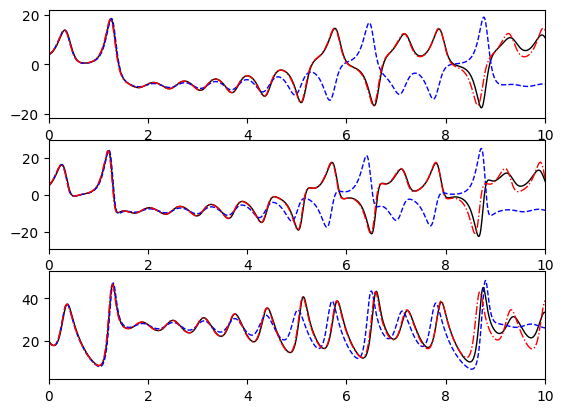

In [17]:
linewidth = 1
tmax = 10
plt.figure()
plt.subplot(311)
plt.plot(t, signal_tanh[:, 0], "k-", linewidth=linewidth)
plt.plot(t, prediction_oect[:, 0], "b--", linewidth=linewidth)
plt.plot(t, prediction_tanh[:, 0], "r-.", linewidth=linewidth)
plt.xlim([0, tmax])

plt.subplot(312)
plt.plot(t, signal_tanh[:, 1], "k-", linewidth=linewidth)
plt.plot(t, prediction_oect[:, 1], "b--", linewidth=linewidth)
plt.plot(t, prediction_tanh[:, 1], "r-.", linewidth=linewidth)
plt.xlim([0, tmax])

plt.subplot(313)
plt.plot(t, signal_tanh[:, 2], "k-", linewidth=linewidth)
plt.plot(t, prediction_oect[:, 2], "b--", linewidth=linewidth)
plt.plot(t, prediction_tanh[:, 2], "r-.", linewidth=linewidth)
plt.xlim([0, tmax])

plt.show()